In [1]:
import pandas as pd
import os
import numpy as np
import os
import sys
sys.path.append(os.path.abspath(".."))
from pathlib import Path
from dateutil.parser import parse
import seaborn as sns
import matplotlib.pyplot as plt 
from pivottablejs import pivot_ui
from google.cloud import bigquery

In [43]:
from liquor_app.interface.main import preprocess
from liquor_app.ml_logic.data import get_data_with_cache
from liquor_app.ml_logic.preprocessor import preprocess_features,create_sequences, create_sequences_padre
from liquor_app.params import *

ImportError: cannot import name 'create_sequences' from 'liquor_app.ml_logic.preprocessor' (/home/renanhilinski/.pyenv/versions/3.10.6/envs/liquor_demand_forecasting/lib/python3.10/site-packages/liquor_app/ml_logic/preprocessor.py)

In [44]:
pd.set_option('display.max_columns', None) # or other number has no effect

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
data_path = '../data/raw/data.csv'

In [47]:
data = pd.read_csv(data_path)

In [49]:
data_preproc_path = '../data/processed/data_processed.csv'

In [50]:
data_preproc = pd.read_csv(data_preproc_path)

In [51]:
data_preproc.head()

,cat_preproc__county_BLACK_HAWK,cat_preproc__county_JOHNSON,cat_preproc__county_LINN,cat_preproc__county_OTHER,cat_preproc__county_POLK,cat_preproc__county_SCOTT,cat_preproc__category_name_GIN,cat_preproc__category_name_LIQUEURS,cat_preproc__category_name_OTROS,cat_preproc__category_name_RUM,cat_preproc__category_name_TEQUILA_MEZCAL,cat_preproc__category_name_VODKA,cat_preproc__category_name_WHISKY,num_preproc__week_year,num_preproc__week_of_year,num_preproc__bottles_sold,remainder__date_week,remainder__sin_MoSold,remainder__cos_MoSold,category_name,county,sin_MoSold,cos_MoSold,bottles_sold
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.166667,0.962963,-0.299712,2012-12-30,-2.449294e-16,1.000000,GIN,BLACK HAWK,-2.449294e-16,1.000000,12
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,-0.962963,-0.302594,2013-01-06,5.000000e-01,0.866025,GIN,BLACK HAWK,5.000000e-01,0.866025,11
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,-0.925926,-0.236311,2013-01-13,5.000000e-01,0.866025,GIN,BLACK HAWK,5.000000e-01,0.866025,34
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,-0.888889,-0.282421,2013-01-20,5.000000e-01,0.866025,GIN,BLACK HAWK,5.000000e-01,0.866025,18
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,-0.851852,-0.262248,2013-01-27,5.000000e-01,0.866025,GIN,BLACK HAWK,5.000000e-01,0.866025,25


In [53]:
recent = data.query("date_week >= '2018-01-01' and category_name == 'RUM'")

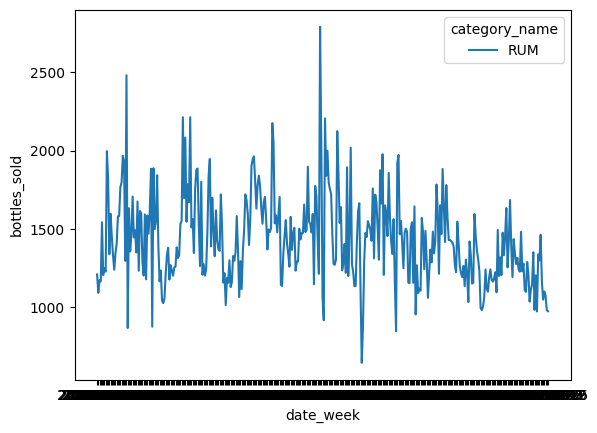

In [58]:
sns.lineplot(recent, x='date_week', y='bottles_sold', hue='category_name', err_style=None);

In [31]:
client = bigquery.Client()

In [35]:
min_date='2013-01-01'
max_date='2023-06-30'

In [39]:
query = f"""
        with clean_data as (
                select * EXCEPT (store_number, zip_code, category, vendor_number, county_number),
                CAST(store_number AS NUMERIC) as store_number ,
                CAST(zip_code AS NUMERIC) as zip_code ,
                CAST(category AS NUMERIC) as category,
                CAST(vendor_number AS NUMERIC) as vendor_number
                from `bigquery-public-data.iowa_liquor_sales.sales`
                where date >= '{min_date}' and date <= '{max_date}'
                --and CAST(vendor_number AS NUMERIC) in (260,421,65,370,85,434,35,301,259,115,395,55,420,205,380,192,297,300,255,389)
                ORDER BY date ASC
        ),
        distinct_vendor as (
                select
                CAST(vendor_number AS NUMERIC) as vendor_number,
                ARRAY_TO_STRING(ARRAY_AGG(vendor_name ORDER BY date DESC LIMIT 1),"") as vendor_name
                from `bigquery-public-data.iowa_liquor_sales.sales`
                group by 1
        ),
        distinct_category as (
                select
                CAST(category AS NUMERIC) as category,
                ARRAY_TO_STRING(ARRAY_AGG(category_name ORDER BY date DESC LIMIT 1),"") as category_name
                from `bigquery-public-data.iowa_liquor_sales.sales`
                group by 1
        ),
        distinct_store as (
                select
                CAST(store_number AS NUMERIC) as store_number,
                ARRAY_TO_STRING(ARRAY_AGG(store_name ORDER BY date DESC LIMIT 1),"") as store_name
                from `bigquery-public-data.iowa_liquor_sales.sales`
                group by 1
        ), clean_data2 as (
        select
                cd.* EXCEPT (vendor_name, category_name, store_name),
                dv.vendor_name,
                dc.category_name,
                ds.store_name
        from clean_data cd
        left join distinct_vendor dv on cd.vendor_number = dv.vendor_number
        left join distinct_category dc on cd.category = dc.category
        left join distinct_store ds on cd.store_number = ds.store_number
        ), group_and_others as (
        SELECT date,
        case when county in ('POLK','LINN','SCOTT','BLACK HAWK','JOHNSON') then county else 'OTHER' END AS county, #'POTTAWATTAMIE','DUBUQUE','STORY','WOODBURY','DALLAS'
        CASE
        WHEN category_name like '%RUM%' THEN 'RUM'
        WHEN category_name like '%VODKA%' THEN 'VODKA'
        WHEN category_name like '%WHISK%' or  category_name like '%SCOTCH%' THEN 'WHISKY'
        WHEN category_name like '%TEQUILA%' or category_name like '%MEZCAL%' THEN 'TEQUILA_MEZCAL'
        WHEN category_name like '%LIQUEUR%' THEN 'LIQUEURS'
        WHEN category_name like '%GIN%' THEN 'GIN'
        else 'OTROS'
        end as category_name,
        case when vendor_name in ('SAZERAC COMPANY  INC','DIAGEO AMERICAS','HEAVEN HILL BRANDS','LUXCO INC','JIM BEAM BRANDS','FIFTH GENERATION INC','PERNOD RICARD USA','MCCORMICK DISTILLING CO.','BACARDI USA INC','E & J GALLO WINERY') then vendor_name else 'OTHER' END as vendor_name,
        sum(bottles_sold) as bottles_sold
        FROM clean_data2
        group by 1,2,3,4
        ), summary as (
        select
        * EXCEPT (vendor_name)
        from group_and_others
        where lower(vendor_name) like '%bacardi%'
        ), combinations as (
        SELECT
          *
          FROM UNNEST(GENERATE_DATE_ARRAY('{min_date}', '{max_date}', INTERVAL 1 DAY)) as date
          cross join (select distinct category_name from summary) a
          cross join (select distinct county from summary) b
          ), data_combinations as (
        select c.*,
        date_trunc(c.date, MONTH) as date_week,
          coalesce(s.bottles_sold,0) as bottles_sold
          from combinations c
          left join summary s on c.date = s.date and c.category_name = s.category_name and c.county = s.county
          )
          select date_week, category_name, county,
          extract(YEAR FROM date_week) as week_year,
          extract(MONTH from date_week) as week_of_year,
           sum(bottles_sold) as bottles_sold
           from data_combinations
           group by 1,2,3,4,5
           order by county asc, category_name asc, date_week asc
"""

In [40]:
df = client.query(query).to_dataframe()

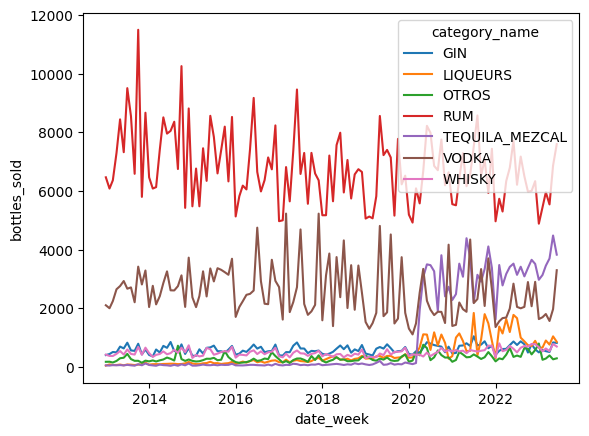

In [41]:
sns.lineplot(df, x='date_week', y='bottles_sold', hue='category_name', err_style=None);